In [1]:
from glob import glob
import os

from PIL import Image

# I'm using MongoDB as my vector database:
from pymongo import MongoClient
from pymongo.errors import CollectionInvalid

from transformers import ViTFeatureExtractor, ViTModel

from glob import glob

from huggingface_hub import login

import certifi


c:\Me\Duke\Classes\Summer '24\MLOps\cinelens\api\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env.local")

True

In [84]:
img_path = "../../misc/images" # share the path of all your images in local folder or S3 bucket
labels_list = [label for label in os.listdir(img_path)]
print(f"Dataset Labels: {labels_list}")

Dataset Labels: ['batsy_1.jpeg', 'batsy_2.jpg', 'batsy_3.jpg', 'batsy_4.png', 'batsy_5.jpg', 'homie_1.jpg', 'homie_2.jpg', 'homie_3.jpg', 'homie_4.jpg', 'homie_5.jpg', 'mb_1.jpg', 'mb_2.jpg', 'mb_3.jpg', 'mb_4.jpg', 'mb_5.jpg', 'thomas_1.jpg', 'thomas_2.jpg', 'thomas_3.jpg', 'thomas_4.jpg', 'thomas_5.png']


In [85]:
images = list()
for i in glob(f"{img_path}/*"):
    images.append(i)
len(images) # find the size of all the images

20

In [7]:
# Load model directly
HF_TOKEN = os.getenv("HF_TOKEN")

login(token=HF_TOKEN)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\91939\.cache\huggingface\token
Login successful


c:\Me\Duke\Classes\Summer '24\MLOps\cinelens\api\.venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
def generate_image_embeddings(myImage):
    image = Image.open(myImage).convert('RGB')

    print(type(image))

    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.tolist()
    return embeddings[0][0]

In [86]:
alldata = list()
for index, y in enumerate(images): # store images and their corresponding embeddings
    alldata.append({
        "image_path" : images[index],
        "embeddings" : generate_image_embeddings(images[index])
    })

In [10]:
import os

MONGODB_URI = os.getenv("MONGO_URI")

ca = certifi.where()

client = MongoClient(MONGODB_URI, tlsCAFile=ca)
# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [87]:
db = client["test-img"]

# Ensure the collection exists, because otherwise you can't add a search index to it.
try:
    db.create_collection("test-2")
except CollectionInvalid:
 print("Images collection already exists")

Images collection already exists


In [93]:
collection = db["test-2"]

result = collection.insert_many(alldata)

# result = collection.update_many(filter={}, update=alldata, upsert=True)

document_ids = result.inserted_ids
print("# of documents inserted: "+str(len(document_ids)))
#print(f"_id of inserted document: {document_ids}")
print("Process Completed!")

In [95]:
img_name = images[1] # Define the image to query
# Create the querying image embeddings
q_image_embeddings = generate_image_embeddings(img_name)

<class 'PIL.Image.Image'>


In [78]:
pipeline = [
    {
        "$vectorSearch": {
            "index": "vector_index",
            "path": "embeddings",
            "queryVector": q_image_embeddings,
            "numCandidates": 5,
            "limit": 5,
        }
    },
    {
        "$project": {
            "_id": 0,
            "image_path": 1,
            "score": {
                "$meta": "vectorSearchScore"
            }
        }
    }
]

results = collection.aggregate(pipeline)

results = [document for document in results]


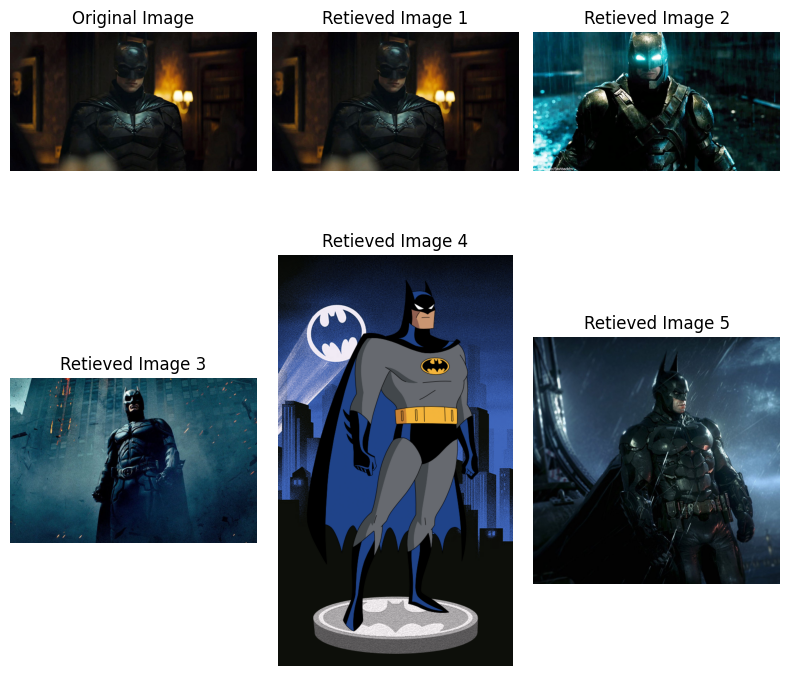

In [79]:
from matplotlib import pyplot as plt
import numpy as np

images_to_plot = [img_name]

count = 1

for document in results:
    count += 1

    images_to_plot.append(document['image_path'])

images_to_plot = [Image.open(img_path) for img_path in images_to_plot]
# Create a 2x3 subplot
fig, axs = plt.subplots(2,3, figsize=(8,8))
axs = axs.ravel()
for i, img in enumerate(images_to_plot):
    axs[i].imshow(np.asarray(img))
    if i == 0:

        axs[i].set_title("Original Image")
        axs[i].axis('off')
    else:
        axs[i].set_title(f"Retieved Image {i+0}")
        axs[i].axis('off')

plt.tight_layout()
plt.show()

In [80]:
count

6

In [81]:
for i in results:
    print(i)

{'image_path': '../../misc/images\\batsy_2.jpg', 'score': 1.0}
{'image_path': '../../misc/images\\batsy_3.jpg', 'score': 0.8939131498336792}
{'image_path': '../../misc/images\\batsy_1.jpeg', 'score': 0.8908010721206665}
{'image_path': '../../misc/images\\batsy_4.png', 'score': 0.8343542218208313}
{'image_path': '../../misc/images\\batsy_5.jpg', 'score': 0.8282822370529175}


In [83]:
# generate_image_embeddings("the batman")